<a href="https://colab.research.google.com/github/otoperalias/Coyuntura/blob/main/clases/Tema3_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tema 3.4. Construcción automática de modelos ARIMA

## *Método artesanal*: a través de bucles:

Encontrar el mejor modelo de manera manual en muchas ocasiones no es operativo, sobre todo cuando tenemos que repetir la tarea con muchas series o con cierta frecuencia. Por ello, es aconsejable automatizar el proceso. Una opción es a través de bucles, probando todas las combinaciones posibles de (p,d,q)(P,D,Q) y quedándonos con la que arroje un menor AIC. Veamos cómo sería.

In [1]:
# Instalamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = [10,4]  # Default figure size

In [60]:
# Importamos los datos usados en el notebook 3.5
medic = pd.read_csv("https://raw.githubusercontent.com/otoperalias/Coyuntura/main/clases/datos/medicamentos_ventas.csv",index_col=0,parse_dates=True)
visit = pd.read_excel("https://github.com/otoperalias/Coyuntura/raw/refs/heads/main/clases/datos/medic_visitas_doctor.xlsx", index_col=0, parse_dates=True)

# Indicamos la frecuencia de los datos (para evitar luego los mensajes warnings en el output)
medic.index.freq = 'MS'
visit.index.freq = 'MS'

# Creamos train y test dataset
train=medic[:-24]
test=medic[-24:]

In [61]:
# Definimos la función
from statsmodels.tsa.statespace.sarimax import SARIMAX

def manual_arima(data, max_p=3, max_d=2, max_q=3,  max_P=3,  max_D=2, max_Q=3, M=12):

    n=0
    best_aic = float('inf')
    best_params = None

    # Test all parameter combinations with nested loops
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                for P in range(max_P + 1):
                    for D in range(max_D+1):
                        for Q in range(max_Q + 1):
                            model = SARIMAX(
                                data,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, M)
                                )
                            aic = model.fit().aic

                            n+=1
                            print(f"Model #{n}")
                            print(f"({p},{d},{q})x({P},{D},{Q}) - AIC: {aic}")

                            if aic < best_aic:
                                best_aic = aic
                                best_params = (p, d, q, P, D, Q)

    return best_params, best_aic

In [ ]:
train.index.freq = 'MS' # to avoid
best_params, best_aic=manual_arima(train, max_p=2, max_d=1, max_q=2,  max_P=1,  max_D=1, max_Q=1)

In [63]:
print(best_params)
print(best_aic)

(2, 1, 1, 0, 1, 1)
322.40501973618973


## ```statsforecast```

El método artesanal o manual es muy lento. Afortunadamente, hay alternativas. Una librería reciente y potente para construir modelos automáticamente es ```statsforecast```:  
https://nixtlaverse.nixtla.io/statsforecast/index.html

Ofrece una colección de modelos populares de predicción de series temporales univariantes (incluido el ARIMA) optimizados para un alto rendimiento y escalabilidad.

Leer esta guía [QUICK START](https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/getting_started_short.html).  

Como se indica en el enlace, el *input* de ```StatsForecast``` siempre es un dataframe en formato largo con tres columnas: ```unique_id```, ```ds``` e ```y```.

* La columna ```unique_id``` (*string*, entero o categoría) representa un identificador para la serie.

* La columna ```ds``` (*datestamp*) debe tener un formato de fechas/periodos compatible con Pandas, idealmente AAAA-MM-DD.

* La columna ```y``` (numérica) representa la medición que se desea predecir.

### Instalación en Google Colab

Dado que la librería no viene pre-instalada en Google Colab, es necesario instalarla cada vez que abrimos una sesión en Google Colab. Esto toma unos segundos.

In [ ]:
pip install statsforecast

### Importar librerías y procesar datos

A continuación importamos la librería recien instalada, junto a la función AutoARIMA de manera separada, así como otras librerías que vamos a usar.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = [10,4]  # Default figure size
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

Es necesario procesar la dataframe ligeramente para ponerla en el formato aceptado por StatsForecast:

In [64]:
medic["unique_id"]="ventas_medic"
medic["ds"]=medic.index
medic['y']=medic['value']
medic.drop(columns=['value'],inplace=True)

Dividimos la serie en train y test dataset:

In [65]:
train=medic[:-24]
test=medic[-24:]

## Especificación y estimación del modelo AutoARIMA

Se especifica y se estima el modelo (tarda unos segundos porque estima muchos modelos hasta encontrar el óptimo):

In [66]:
modelo = StatsForecast(models=[AutoARIMA(season_length=12,
                                         max_p=2, max_d=1, max_q=2, max_P=1, max_D=1, max_Q=1,    # Para replicar los valores máximos establecidos en el método manual
                                          )],freq='MS')
modelo.fit(train)

StatsForecast(models=[AutoARIMA])

El *output* del modelo se puede observar como sigue:

In [67]:
print ("Modelo: (p,q,P,Q,M,d,D): ",modelo.fitted_[0,0].model_['arma'])
print ("Observations",modelo.fitted_[0,0].model_['nobs'])
print ("AIC: ",modelo.fitted_[0,0].model_['aic'])
print ("Coeficientes: ")
for x in modelo.fitted_[0,0].model_['coef']:
  print("  ", x, ":", modelo.fitted_[0,0].model_['coef'][x])

Modelo: (p,q,P,Q,M,d,D):  (2, 1, 0, 1, 12, 1, 1)
Observations 167
AIC:  322.4990687472983
Coeficientes: 
   ar1 : -0.06382055972241654
   ar2 : 0.2514689894350728
   ma1 : -0.8807869909533341
   sma1 : -0.26767754509600866


In [ ]:
forecast_df=modelo.predict(h=len(test), level=[95])
forecast_df # es una dataframe con la predicción y el IC

Dibujamos la predicción:

In [ ]:
# Primero creo un index para forecast_df
forecast_df.set_index(forecast_df.ds, drop=False, inplace=True )

# Gráfico
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(train[-60:]['y'], label="Training period", color="b") #con [-60:] evito representar la serie completa
ax.plot(test['y'], label="Actual values", color="k")
ax.plot(forecast_df['AutoARIMA'], label="Predicted", color='r')
ax.fill_between(forecast_df.index,
                 forecast_df['AutoARIMA-lo-95'],
                 forecast_df['AutoARIMA-hi-95'],
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA - Predicción de ventas de medicamentos")
plt.show()

Comprobamos numéricamente la exactitud de la predicción:

In [70]:
def forecast_accuracy(forecast, actual):
    rmse = np.sqrt(np.mean((forecast-actual)**2))
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    print({'rmse':rmse,'mape':mape,'corr':corr})

forecast_accuracy(forecast_df['AutoARIMA'], test.y)

{'rmse': np.float64(2.871128351003416), 'mape': np.float64(0.11082272976223745), 'corr': np.float64(0.8355835133471282)}


Predecimos también hacia el futuro:

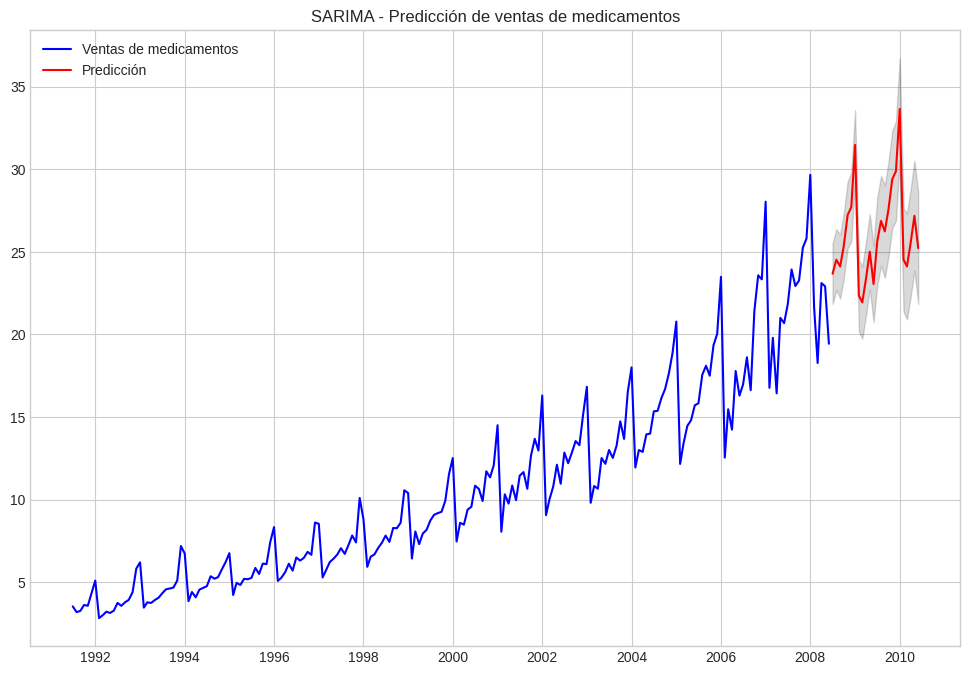

In [80]:
# Especificamos un modelo con los parámetros hallados anteriormente
# Modelo: (p,q,P,Q,M,d,D):  (2, 1, 0, 1, 12, 1, 1) equivale a order=(2, 1, 1) y seasonal_order=(0,1,1)

modelo_fut = StatsForecast(models=[ARIMA(order=(2, 1, 1), seasonal_order=(0,1,1),
                                     include_mean=False, season_length=12)],freq='MS')
modelo_fut.fit(medic)

forecast_df2=modelo_fut.predict(h=24, level=[95])
forecast_df2.set_index(forecast_df2.ds, drop=False, inplace=True )

# Gráfico
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(medic['y'], label="Ventas de medicamentos", color="b") #con [-60:] evito representar la serie completa
ax.plot(forecast_df2['ARIMA'], label="Predicción", color='r')
ax.fill_between(forecast_df2.index,
                 forecast_df2['ARIMA-lo-95'],
                 forecast_df2['ARIMA-hi-95'],
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA - Predicción de ventas de medicamentos")
plt.show()

## Cross-Validation

Para evaluar mejor la capacidad de nuestro modelo para predecir, se puede repetir el proceso de comparar entre nuestra predicción y la test dataset más sistemáticamente, para otras test datasets dentro de nuestro periodo observado.  
  
La librería ```statsforecast```  tiene una función para ello: ```cross_validation()```.

### AutoArima con variable exógena:

In [56]:
# Para saber qué modelo se está estimando

modelo = StatsForecast(models=[ARIMA(order=(2, 0, 2), seasonal_order=(1,0,1),
                                     include_mean=False, season_length=12)],freq='MS')  # Indicamos que son datos sin estacionalidad y la frecuencia es "months start"
modelo.fit(train)
print ("Especificación del modelo: ",modelo.fitted_[0,0].model_['arma'])
print ("Observations",modelo.fitted_[0,0].model_['nobs'])
print ("AIC: ",modelo.fitted_[0,0].model_['aic'])
print ("Coeficientes: ")
for x in modelo.fitted_[0,0].model_['coef']:
  print("  ", x, ":", modelo.fitted_[0,0].model_['coef'][x])

# Equivalente a esto
medic = pd.read_csv("https://raw.githubusercontent.com/otoperalias/Coyuntura/main/clases/datos/medicamentos_ventas.csv",index_col=0,parse_dates=True)
visit = pd.read_excel("https://github.com/otoperalias/Coyuntura/raw/refs/heads/main/clases/datos/medic_visitas_doctor.xlsx", index_col=0, parse_dates=True)
medic.index.freq = 'MS'
train2=medic[:-24]

SARIMAX(train2,order=(2, 0, 2),seasonal_order=(1, 0, 1, 12)).fit().summary()



Especificación del modelo:  (2, 2, 1, 1, 12, 0, 0)
Observations 180
AIC:  386.6873896384608
Coeficientes: 
   ar1 : 0.4256822832840509
   ar2 : 0.5626135933527985
   ma1 : -0.34801845354120065
   ma2 : -0.25417605911327656
   sar1 : 0.974903369893302
   sma1 : -0.22394114401160825


In [23]:
from statsforecast.models import ARIMA